<a href="https://colab.research.google.com/github/Mityal999/Diplom/blob/main/%D0%9D%D0%BE%D0%B2%D0%B5%D0%B9%D1%88%D0%B8%D0%B9_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%92%D0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras import utils
from keras.optimizer_v2.adam import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import MeanAbsolutePercentageError
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# Датасет

##____ выбор

In [ ]:
DATASET = 2  # 0 - google_cluter, 1 - electricity, 2 - air_passengers
USE_SPLIT = 1

##____ подготовка

In [ ]:
if DATASET == 0:
    df = pd.read_csv(f'/content/drive/MyDrive/google_cluster_traces/{USE_SPLIT}_minute_sums.csv')
    data = df['cpu']
    data = np.expand_dims(data, axis=1)

# if DATASET == 1:
    # url = "https://eepublicdownloads.blob.core.windows.net/public-cdn-container/clean-documents/Publications/Statistics/Monthly-hourly-load-values_2006-2015.xlsx"
    # df = pd.read_excel(url, skiprows=3)

if DATASET == 2:
    path = 'https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv'
    df = pd.read_csv(path)
    df.columns = ["time", "value"]
    data = df['value']
    data = np.expand_dims(data, axis=1)

# Выборки

In [ ]:
FOLDS_COUNT = 5
USED_FOLDS = [4]  # 1 максимум

XLEN = 14

LAG = 1
PRED_CHANNEL = 0

In [ ]:
def create_train_val(data):

    #########################
    # Разбиваем на фолды, но берём один последний
    #########################
    tscv = TimeSeriesSplit(n_splits=FOLDS_COUNT)  # объект для разбиения на фолды
    folds_indexes = []
    for train_indexes, val_indexes in tscv.split(data):
        folds_indexes.append([train_indexes, val_indexes])

    train_indexes, val_indexes = folds_indexes[-1]



    #########################
    # Создание выборок
    #########################

    # Извлекаем нужный канал и разбиваем на выборки
    x_train_raw = data[train_indexes, :]
    y_train_raw = data[train_indexes, PRED_CHANNEL]
    y_train_raw = np.expand_dims(y_train_raw, axis=1)

    x_val_raw = data[val_indexes, :]
    y_val_raw = data[val_indexes, PRED_CHANNEL]
    y_val_raw = np.expand_dims(y_val_raw, axis=1)


    # Отцепляем кусок длиной (XLEN + (LAG-1)) от конца train-а, чтобы прогноз val-а был на весь фолд
    x_val_raw = np.concatenate([x_train_raw[-(XLEN + (LAG-1)):], x_val_raw])
    y_val_raw = np.concatenate([y_train_raw[-(XLEN + (LAG-1)):], y_val_raw])

    x_train_raw = x_train_raw[:-(XLEN + (LAG-1))]
    y_train_raw = y_train_raw[:-(XLEN + (LAG-1))]


    # Разбиваем по timestep-ам
    x_train = np.array([   x_train_raw[         i:(i + XLEN)               , :]     for i in range(x_train_raw.shape[0] - XLEN - (LAG - 1))   ])
    y_train = np.array([   y_train_raw[(i + XLEN):(i + XLEN + (LAG - 1)) +1, :]   for i in range(x_train_raw.shape[0] - XLEN - (LAG - 1))   ])

    x_val =   np.array([     x_val_raw[         i:(i + XLEN)               , :]     for i in range(x_val_raw.shape[0]   - XLEN - (LAG - 1))   ])
    y_val =   np.array([     y_val_raw[(i + XLEN):(i + XLEN + (LAG - 1)) +1, :]   for i in range(x_val_raw.shape[0]   - XLEN - (LAG - 1))   ])


    # Нормализация (3D)
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    x_train = x_scaler.fit_transform( x_train.reshape(x_train.shape[0], -1) ).reshape(x_train.shape)
    y_train = y_scaler.fit_transform( y_train.reshape(y_train.shape[0], -1) ).reshape(y_train.shape)

    x_val = x_scaler.transform(x_val.reshape(x_val.shape[0], -1)).reshape(x_val.shape)
    y_val = y_scaler.transform(y_val.reshape(y_val.shape[0], -1)).reshape(y_val.shape)


    return (x_train, y_train), (x_val, y_val), (x_scaler, y_scaler) 

In [ ]:
(x_train, y_train), (x_val, y_val), (x_scaler, y_scaler) = create_train_val(data)

# Модели

##____ объявить список экспертов

### функции

In [ ]:
def create_seq_lstm_model(input_shape=(XLEN, data.shape[1]),
                          
                          L1_units=16,          L2_units=32,            L3_units=0,
                          L1_activation='relu', L2_activation='relu',   L3_activation='relu',
                          L1_dropout=0.1,       L2_dropout=0.1,         L3_dropout=0.1,

                          D1_neurons=64,        D2_neurons=0,
                          D1_activation='relu', D2_activation='relu',
                          D1_dropout=0.3,       D2_dropout=0.2,
                          
                          output_activation='relu'):
    model = Sequential()

    model.add(LSTM(L1_units, activation=L1_activation, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(L1_dropout))

    if L2_units > 0:
        model.add(LSTM(L2_units, activation=L2_activation, return_sequences=True))
        model.add(Dropout(L2_dropout))

    if L3_units > 0:
        model.add(LSTM(L3_units, activation=L3_activation, return_sequences=True))
        model.add(Dropout(L3_dropout))


    model.add(Flatten())


    if D1_neurons > 0:
        model.add(Dense(D1_neurons, activation=D1_activation))
        model.add(Dropout(D1_dropout))

    if D2_neurons > 0:
        model.add(Dense(D2_neurons, activation=D2_activation))
        model.add(Dropout(D2_dropout))


    model.add(Dense(LAG, activation=output_activation))

    return model

In [ ]:
def create_simple_model(input_shape=(XLEN, data.shape[1])):

    model = Sequential()

    model.add(Flatten(input_shape=input_shape))

    model.add(Dense(LAG, activation='relu'))

    return model

### реализация

In [ ]:
blank_models = []
blank_models.append( create_seq_lstm_model() )
blank_models.append( create_seq_lstm_model(L2_units=0, D1_neurons=0) )
blank_models.append( create_seq_lstm_model(L2_units=0) )
blank_models.append( create_seq_lstm_model(L3_units=64) )
# blank_models.append( create_seq_lstm_model(D1_neurons=128) )
# blank_models.append( create_seq_lstm_model(D2_neurons=32) )
blank_models.append( create_simple_model() )

##____ обучение списка экспертов

In [ ]:
T1_EPOCHS = 300
T1_ES_PATIENCE = T1_EPOCHS // 3
T1_lr = 1e-3
T1_bs = 16

### функции

In [ ]:
def fit_blank_models(blank_models):

    models = []

    for blank_model in blank_models:

        model = fit_blank_model(blank_model)
        models.append(model)

    return models

In [ ]:
def fit_blank_model(model):

    model.compile(loss='mse', optimizer=Adam(learning_rate=T1_lr))

    es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=T1_ES_PATIENCE)
    mcp_path1 = '/content/drive/MyDrive/some_model_weights_T1.mdl_wts.hdf5'
    mcp_save1 = ModelCheckpoint(mcp_path1, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
    callbacks = [es1, mcp_save1]

    history1 = model.fit(   x_train, y_train, 
                            batch_size=T1_bs, 
                            epochs=T1_EPOCHS, 
                            verbose=0,
                            validation_data=(x_val, y_val),
                            callbacks=callbacks)

    model.load_weights(mcp_path1)


    # Графики ошибок
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    print('\n', '\n', '\n', 'Yet another model:')
    plt.plot(np.log(loss))
    plt.plot(np.log(val_loss))
    plt.grid()
    plt.show()


    return model

### реализация


 
 
 Yet another model:


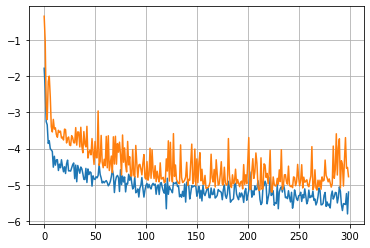


 
 
 Yet another model:


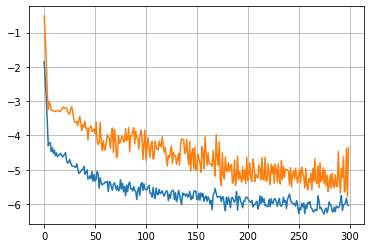


 
 
 Yet another model:


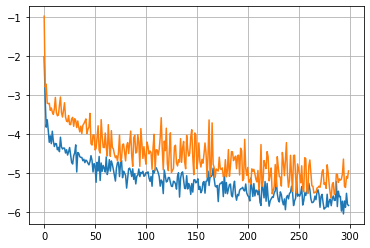


 
 
 Yet another model:


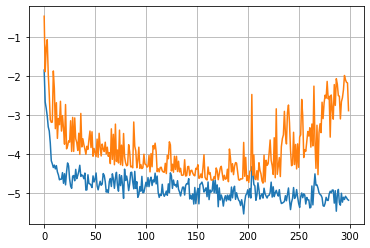


 
 
 Yet another model:


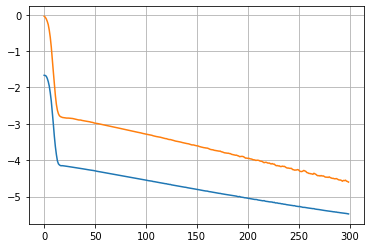

In [ ]:
models = fit_blank_models(blank_models)

#Specialized losses

##____ cоздать ядра

### функции

In [ ]:
def fill_array_to_size(arr, size):
    
    delta = size - arr.shape[0]

    res = np.full((size, arr.shape[1]), np.nan)
    res[:size-delta] = arr

    for i in range(size-delta, size):
        res[i,:] = res[size-delta-1,:]
    
    return res

### реализация

In [ ]:
data
d1 = data[1:] - data[:-1]
d2 = d1[1:] - d1[:-1]

In [ ]:
d1 = fill_array_to_size(d1, data.shape[0])
d2 = fill_array_to_size(d2, data.shape[0])

In [ ]:
abs_d1 = np.abs(d1)
abs_d2 = np.abs(d2)

In [ ]:
# mean
mean_abs_d1 = np.mean(abs_d1)
mean_abs_d2 = np.mean(abs_d2)

In [ ]:
cores = []
cores.append( (abs_d1 > mean_abs_d1).astype(int) ) 
cores.append( (abs_d2 > mean_abs_d2).astype(int) ) 

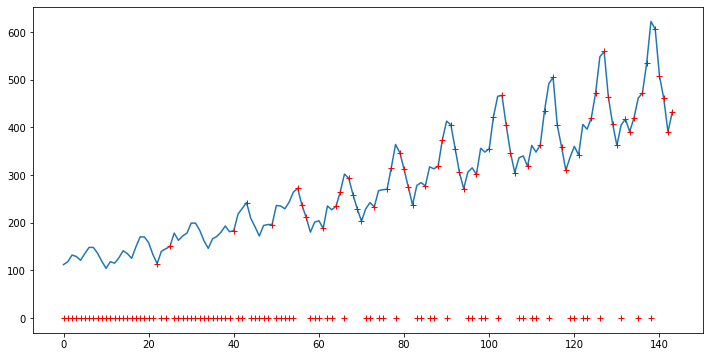

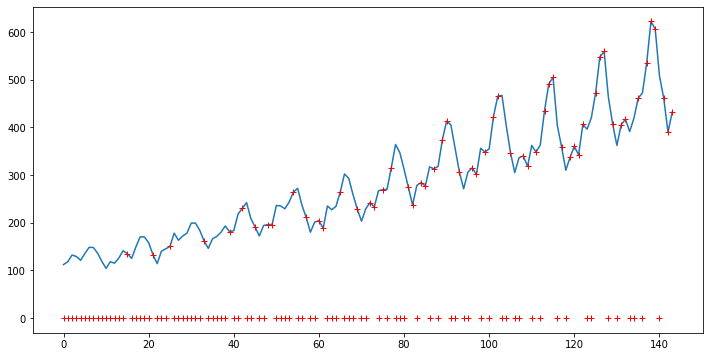

In [ ]:
for core in cores:    

    cored_data = data * core

    plt.figure(figsize=(12,6))
    plt.plot(data)
    plt.plot(cored_data, 'r+')
    plt.show()

##____ получить abs_loss

In [ ]:
model_abs_losses_by_lags = []

for model in models:

    pred = model.predict(x_val)
    model_loss_by_lags = np.squeeze(y_val) - pred
    model_abs_loss_by_lags = np.abs(model_loss_by_lags)
    model_abs_losses_by_lags.append(model_abs_loss_by_lags)

In [ ]:
# Суммируем по lag-ам

model_abs_losses = []

for model_abs_loss_by_lags in model_abs_losses_by_lags:

    model_abs_loss = np.sum(model_abs_loss_by_lags, axis=1)
    model_abs_losses.append(model_abs_loss)

##____ применить ядра к abs_loss

In [ ]:
cores_arr = np.squeeze( np.array(cores) )
val_cores_arr = cores_arr[:, -y_val.shape[0]:]

model_abs_losses_arr = np.array(model_abs_losses)

# val_cores_arr * model_abs_losses_arr.T

In [ ]:
cored_model_mae = np.zeros( (val_cores_arr.shape[0], model_abs_losses_arr.shape[0]) )

for i, val_core in enumerate(val_cores_arr):

    for j, model_abs_loss in enumerate(model_abs_losses):

        cored_model_abs_loss = val_core * model_abs_loss
        cored_model_mae[i, j] = np.mean(cored_model_abs_loss)

In [ ]:
cored_model_mae

array([[3.9355744 , 3.85488763, 3.93352922, 3.80003258, 4.02097124],
       [3.97209833, 4.04501142, 4.23065841, 3.76043178, 4.04039161]])

In [ ]:
pd.DataFrame(cored_model_mae, index=['high_d1', 'high_d2'], columns=['e_1', 'e_2', 'e_3', 'e_4', 'e_5'])

,e_1,e_2,e_3,e_4,e_5
high_d1,3.935574,3.854888,3.933529,3.800033,4.020971
high_d2,3.972098,4.045011,4.230658,3.760432,4.040392
